In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from numpy import NaN
import math
import matplotlib
from geopy.distance import vincenty


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Define Input File

In [2]:
fileRead = "../data/SFO_Arrivals.csv"
data = np.genfromtxt(fileRead, delimiter=',',skip_header=1)
# print all(isinstance(x, float) for x in data)

num_flights, _ = data.shape
print "num of lines in file", num_flights
unique_flightIds = np.unique(data[:,0]).tolist()
print "num_flights", len(unique_flightIds)


num of lines in file 3582
num_flights 192


# Plot all SFO Arrivals and compare UA728 wrt EHeight

/home/etc/anaconda2/envs/py276/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


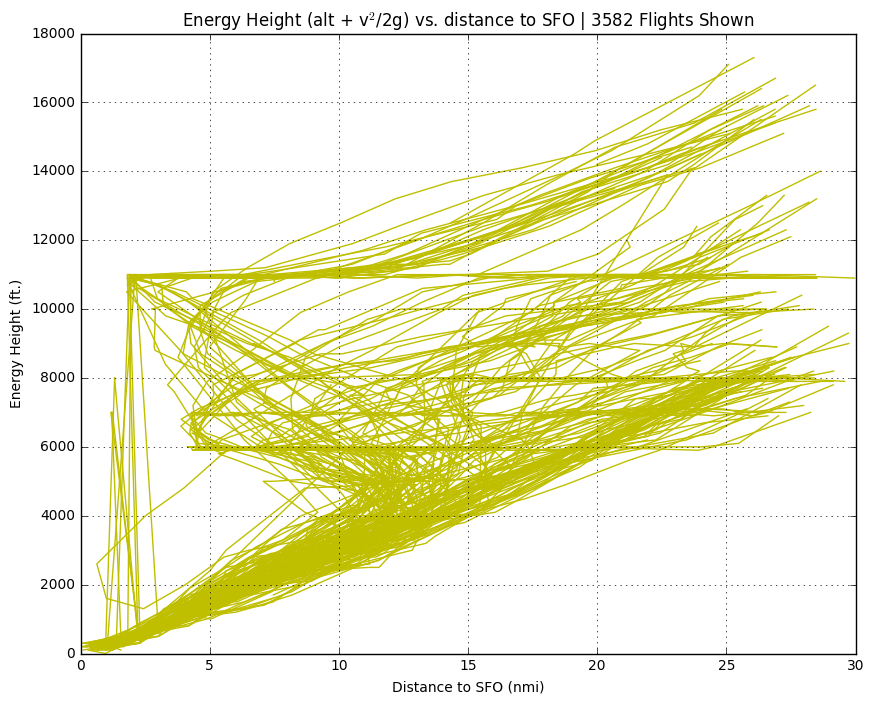

In [3]:
x = []
y = []
dist2sfo = []
eheight = []
all_lat = []
all_lon = []
all_alt_ft = []
flight_ids = []

oldFlightId=0

for i in range(num_flights):
    flightId = data[i,0]
    if flightId==oldFlightId:
        flight_ids.append(data[i,0])
        x.append(data[i,1]) #dist 
        all_lat.append(data[i,3])
        dist2sfo.append((data[i,1]))
        eheight.append((data[i,2]))
        y.append(data[i,5]) #eheight
        all_lon.append(data[i,4])
        all_alt_ft.append(data[i,5])
        
#         if (float(data[i,1]) < 2 and float(data[i,2]) > 10000):
#             print " wierd flight = ", flightId, ',', float(data[i,1]), ', ',float(data[i,2])
                 
    else:
        plt.plot(x,y,'y-')
        oldFlightId = flightId
        flight_ids.append(data[i,0])
        all_lat.append(data[i,3])
        dist2sfo.append((data[i,1]))
        eheight.append((data[i,2]))
        all_lon.append(data[i,4])
        all_alt_ft.append(data[i,5])
        x=[]
        y=[]
plt.title(r'Energy Height (alt + v$^2$/2g) vs. distance to SFO | %s Flights Shown'%(num_flights))
plt.xlabel('Distance to SFO (nmi)')
plt.ylabel('Energy Height (ft.)')
plt.grid()

#plt.show()

## print all(isinstance(int(round(x)), int) for x in dist2sfo)
## Compute average and std. deviation at each NM from SFO
dist2sfoRound = [int(round(x)) for x in dist2sfo]
avgHeightArray = np.zeros([len(dist2sfo),31]) ## to compute avg eheight
heightPerFlight = np.zeros([len(unique_flightIds),100])

temp = []
## Compute averge eheight for each flight
for i,val in enumerate(dist2sfoRound):
    # Val is distance from SFO
    # Add flight values to row at index in unique_flightIds
    # Check if flight id was set
    if flight_ids[i] in heightPerFlight[:,0]:
        row = unique_flightIds.index(flight_ids[i]) 
        col_list = [ii for ii,xx in enumerate(heightPerFlight[row,0:]) if xx>0]
        col = max(col_list)
        heightPerFlight[row,col+1] = eheight[i]
#         print ('flight Id %s insert at %s,%s value %s'%(flight_ids[i],row,str(col+1),str(eheight[i])))
    else:
        row = unique_flightIds.index(flight_ids[i])
        heightPerFlight[row,0] = flight_ids[i]
        heightPerFlight[row,1] = eheight[i]

#     nonemptyrow = next((ii for ii, j in enumerate(avgHeightArray[:,val]) if j==0), -1)
#     # Comment: Remove spurious data -> High EHeight at low dist from SFO
#     if ((val < 3 and eheight[i] < 5000) or (val>=3)):
#         avgHeightArray[nonemptyrow,val] = eheight[i]
    
heightPerFlight[heightPerFlight==0] = np.nan

#########################
#########  Compute averages
#########################

avgHeightPerFlight = np.zeros([len(unique_flightIds),2])
for i,val in enumerate(unique_flightIds):
    avgHeightPerFlight[i,0]=val
    avgHeightPerFlight[i,1]=np.nanmean(heightPerFlight[i,1:])

avgHeightPerFlight = avgHeightPerFlight[np.argsort(avgHeightPerFlight[:,1])]
# avgHeightPerFlight.sort(axis=1)
avgHeightPerFlight = avgHeightPerFlight[::-1] # sort descending
topDefaulter = avgHeightPerFlight[[ii for ii,jj in enumerate(avgHeightPerFlight[0:10,1]) if math.isnan(jj)==False],0].tolist()


## Plot the top defaulter

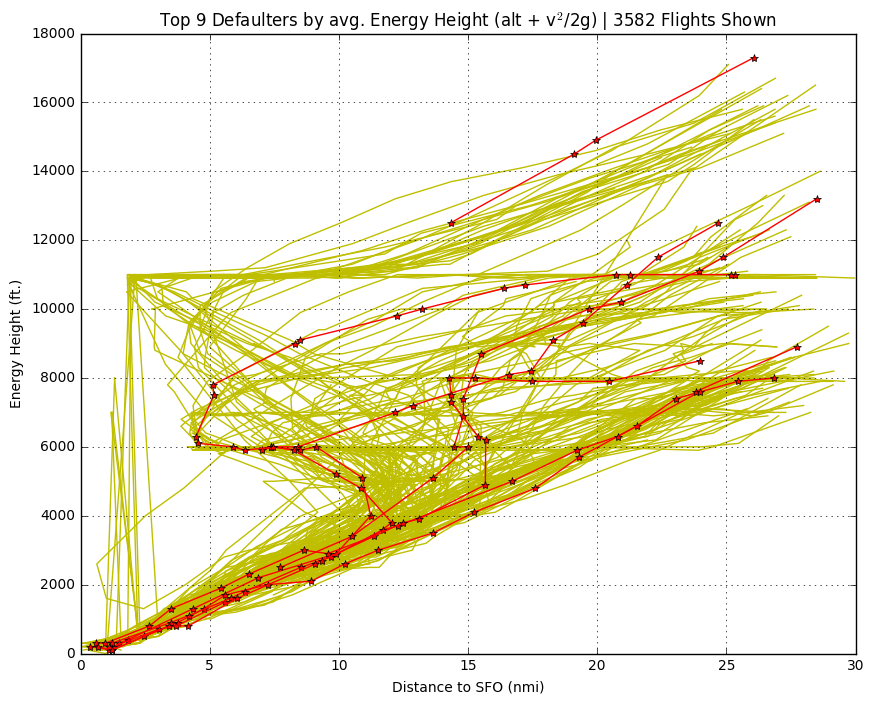

In [4]:
x=[]
y=[]

for i in range(num_flights):
    flightId = data[i,0]
    if flightId==oldFlightId:
        x.append(data[i,1]) #dist 
        y.append(data[i,5]) #eheight
#         if (float(data[i,1]) < 2 and float(data[i,2]) > 10000):
#             print " wierd flight = ", flightId, ',', float(data[i,1]), ', ',float(data[i,2])
                 
    else:
        if (flightId in topDefaulter):
            plt.plot(x,y,'r*-')
        else:
            plt.plot(x,y,'y-',zorder=0)
        oldFlightId = flightId
        x=[]
        y=[]
plt.title(r'Top %s Defaulters by avg. Energy Height (alt + v$^2$/2g) | %s Flights Shown'%(len(topDefaulter),num_flights))
plt.xlabel('Distance to SFO (nmi)')
plt.ylabel('Energy Height (ft.)')
plt.grid()